# Diagnostic Video

Creating time-lapse videos from sequences of night sky images is a powerful diagnostic tool for astronomers. Such videos can reveal evolving patterns in seeing conditions, tracking accuracy, cloud coverage, and equipment performance—details that may be missed when examining individual frames.

In this tutorial, we will transform the calibrated astronomical images from the [calibration tutorial](calibration) into a time-lapse video of the night.

## Selecting and Sorting Files

Let's begin by retrieving the files.

In [1]:
from glob import glob

images = glob("calibrated_images/*.fits")

Next, we sort the files by observation time.

In [2]:
from astropy.io import fits
from dateutil import parser


def observation_time(file):
    date_str = fits.getheader(file)["DATE-OBS"]
    return parser.parse(date_str)


# order by observation time
images = sorted(images, key=lambda file: observation_time(file))

## Creating a Video in the Notebook

We will now define a small function to display an image along with some relevant information.

This function will be used to visualize individual frames.

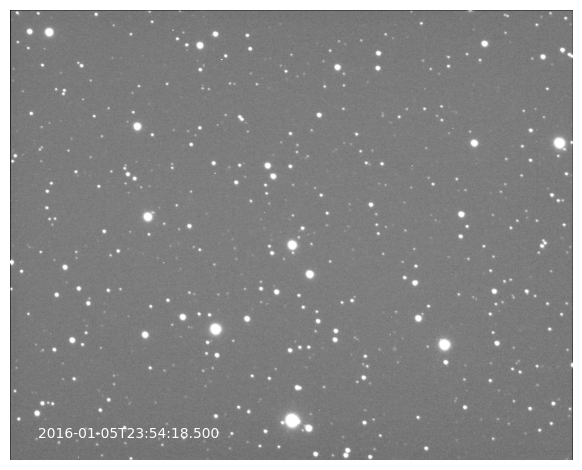

In [3]:
import matplotlib.pylab as plt
from eloy import viz


def show_image(file, ax=None):
    data = fits.getdata(file)
    header = fits.getheader(file)
    if ax is None:
        ax = plt.gca()
    ax.imshow(viz.z_scale(data), cmap="Greys_r", origin="lower")
    ax.text(
        0.05, 0.05, header["DATE-OBS"], color="white", transform=plt.gca().transAxes
    )
    ax.axis("off")
    plt.gcf().patch.set_alpha(0.0)
    plt.tight_layout()


show_image(images[0])

Let's use this function to create a video of the night directly in the notebook. For demonstration purposes, we'll use only the first $n$ images.

In [4]:
import matplotlib.animation as animation
from IPython import display
import imageio.v2 as imageio
import io

FPS = 10
fig, ax = plt.subplots()


def init():
    show_image(images[0], ax=ax)
    im = fig.axes[0].images[0]
    return [im]


def update(frame):
    ax.clear()
    show_image(images[frame], ax=ax)
    return [ax.images[0]]


ani = animation.FuncAnimation(
    fig, update, init_func=init, frames=10, interval=1000 / FPS, blit=True
)
video = ani.to_jshtml(embed_frames=True)
html = display.HTML(video)
plt.close()
display.display(html)

## Saving the Video Locally

To save the video locally, we use [this matplotlib feature](https://matplotlib.org/stable/users/explain/animations/animations.html#saving-animations), which requires [ffmpeg](https://ffmpeg.org/) to be installed.

In [5]:
ani.save("night_video.mp4", writer="ffmpeg")
plt.close()

## Creating Videos in a Pipeline

It is common to generate plots and save videos while performing other tasks on each image within a processing loop. For this purpose, the [imageio](https://imageio.readthedocs.io/) library is especially convenient. Here, we define a function that writes a matplotlib plot directly into an imageio writer.

In [6]:
def write_plot(writer):
    buf = io.BytesIO()
    plt.savefig(buf)
    writer.append_data(imageio.imread(buf))
    plt.close()

Now, let's create a loop in which we perform some image processing tasks while generating a video based on a plot.

Note how the writer is instantiated before the loop and closed at the end.

In [7]:
import numpy as np
from eloy import utils, detection, viz


writer = imageio.get_writer("night_video.mp4", mode="I", fps=10, format="FFMPEG")

for file in images[10:30]:
    data = fits.getdata(file)  # load the data to avoid caching issues

    # as an example we make a cutout of the image and display some detected stars
    cutout = utils.cutout(data, [(1000, 500)], (300, 300))[0]
    regions = detection.stars_detection(cutout, threshold=1)
    coords = np.array([r.centroid_weighted[::-1] for r in regions])

    # the plotting part
    plt.figure(figsize=(5, 5))
    plt.imshow(cutout)
    viz.plot_marks(*coords.T)
    plt.tight_layout()

    write_plot(writer)

writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Here is the generated video.

In [8]:
from IPython.display import Video

Video(
    "night_video.mp4",
    embed=True,
    width=600,
    height=400,
    html_attributes="controls autoplay loop",
)